#  Data Retreival Tool: AHPS
### Valid For Stations with Stage & Flow data 

In [1]:
#Import Libraries
import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, HourLocator, DateFormatter
% matplotlib notebook
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timezone

In [2]:
#--Example ahps stations:
alex = 'AXTV2'    
cbbt = 'CBBV2'
wadc ='WASD2'
gtwn ='GTND2'
l_falls = 'BRKM2'
mach_ck = 'NCDV2'
anapolis = 'APAM2'

gage = alex

In [3]:
#---Read HTML
url = r'http://water.weather.gov/ahps2/hydrograph_to_xml.php?gage={}&output=tabular'.format(gage)
r = requests.get(url)
data = r.text
soup = BeautifulSoup(data, "lxml")

#---Data
data = soup.find_all('table')[0] 
data_rows = data.find_all('tr')[3:]

#--Get the Current Year in UTC
year = datetime.now(timezone.utc).strftime("%Y")

In [4]:
#--Get the Current Year in UTC
year = datetime.now(timezone.utc).strftime("%Y")

#--Initialize Dictionaries
obs_data =  {'Date(UTC)' : [], 'Flow' : [], 'Stage' : []}
forecast_data = {'Date(UTC)' : [], 'Flow' : [], 'Stage' : []}

#---Extract Values to Dictionaries
value = 'Observed'

for row in data_rows:
    d = row.find_all('td')
    try:
        dtm   = d[0].get_text().split()[0] + '/' + str(year) +' '+ d[0].get_text().split()[1]
        stage = d[1].get_text()
        flow  = d[2].get_text()
    
        if value == 'Observed':
            obs_data['Date(UTC)'].append(dtm) 
            obs_data['Flow'].append(flow)
            obs_data['Stage'].append(stage)

        elif value =='Forecast':
            forecast_data['Date(UTC)'].append(dtm) 
            forecast_data['Flow'].append(flow)
            forecast_data['Stage'].append(stage)

    except:
        check_value = str(d)
        if 'Forecast  Data ' in check_value:
            value = 'Forecast'
      

In [5]:
#---Create & Format Dataframes
df_obs = pd.DataFrame.from_dict(obs_data)
df_obs['Date(UTC)'] = pd.to_datetime(df_obs['Date(UTC)'], format='%m/%d/%Y %H:%M')
df_obs['Stage'] = df_obs['Stage'].astype(str).str[:-2].astype(np.float)
df_obs = df_obs.set_index(df_obs['Date(UTC)'] )

df_fcst = pd.DataFrame.from_dict(forecast_data)   
df_fcst['Date(UTC)'] = pd.to_datetime(df_fcst['Date(UTC)'], format='%m/%d/%Y %H:%M')
df_fcst['Stage'] = df_fcst['Stage'].astype(str).str[:-2].astype(np.float)
df_fcst = df_fcst.set_index(df_fcst['Date(UTC)'] )

#start, stop = df_obs.index[0], df_fcst.index[-1]
#idx = pd.date_range(start,stop,freq='15T')

<IPython.core.display.Javascript object>


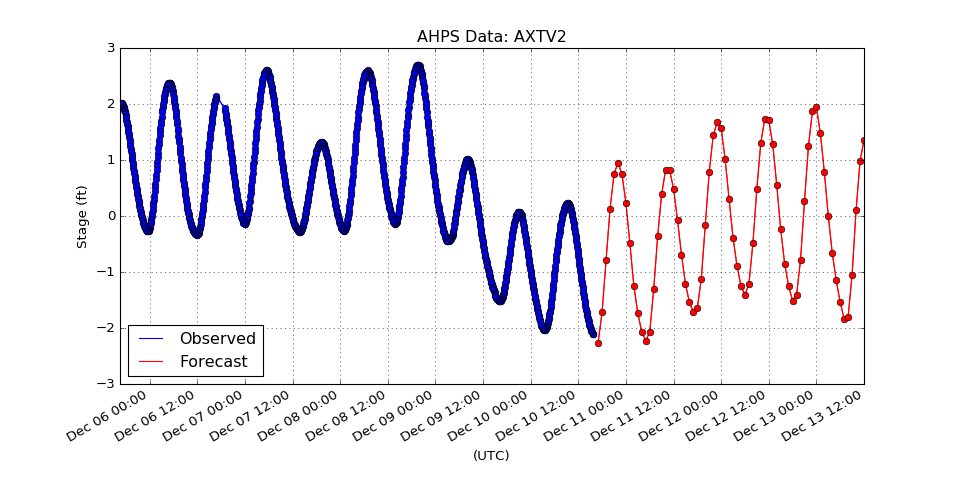

In [6]:
#--Initialize Plots
fig, ax = plt.subplots(figsize=(12,6))

#--Plot Observed
x0 = df_obs['Date(UTC)']
y0 = df_obs['Stage']
ax.plot(x0 ,y0, color = 'b')       # Observed


#--Plot Forecast
x1 = df_fcst['Date(UTC)']
y1 = df_fcst['Stage']
ax.plot(x1 ,y1, color = 'r')       # Observed

#ax.scatter(x,y1,color='b', marker = 'o', s= 55, facecolors='none')      # Forecast


plt.legend(['Observed', 'Forecast'], loc='lower left',scatterpoints = 1)
ax.plot(x0 ,y0, color = 'b', marker = 'o')       # Add Points
ax.plot(x1 ,y1, color = 'r', marker = 'o')       # Add Points

plt.title('AHPS Data: {}'.format(gage))
plt.xlabel('(UTC)')
plt.ylabel('Stage (ft)')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(DateFormatter('%b %d %H:%M'))
plt.gca().xaxis.set_major_locator(HourLocator(np.arange(0, 25, 12)))

plt.gcf().autofmt_xdate()